In [150]:
import math
from datetime import timedelta
from operator import attrgetter

import glob 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import trajan as ta
import xarray as xr
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

import parcels

### Quickstart to WP 1C

#### Load drifter tracks

In [157]:
# Path to the folder containing the drifter CSV files
drifter_folder = r"Y:/PROJECTS/DRIFTERS/data/qc_tdsi_6h"
files = glob.glob(f"{drifter_folder}/*.csv")

# Initialize an empty DataFrame to store all data
drifter_df = pd.DataFrame()

# Iterate over all CSV files in the folder
for file in files: 
    df = pd.read_csv(file)  # Read each file into a DataFrame
    drifter_df = pd.concat([drifter_df, df], ignore_index=True)  # Concatenate to the main DataFrame

# Ensure the 'time' column is in datetime format
drifter_df["time"] = pd.to_datetime(drifter_df["time"])
drifter_df = drifter_df[drifter_df["deployed"] != False]
drifter_df.drop(columns="deployed", inplace=True)

KeyError: 'time'

In [152]:
w, e, s, n = drifter_df.lon.min(), drifter_df.lon.max(), drifter_df.lat.min(), drifter_df.lat.max()
w, e, s, n = int(w), int(e), int(s), int(n)
print("W, E, S, N:", [w, e, s, n])

AttributeError: 'DataFrame' object has no attribute 'lon'

In [4]:
tstart, tend = drifter_df.time.min(), drifter_df.time.max()
print("Time range: ", tstart, tend)

Time range:  2020-01-01 00:00:00+00:00 2025-01-21 01:43:55+00:00


#### Load OGCMs

Amphitrite training period: 2018-2021 and 08/2023-02/2024 

#### Resources <br>
Grid:  <br>
https://cfconventions.org/Data/cf-conventions/cf-conventions-1.7/build/ch05s06.html <br> 
https://www.oc.nps.edu/nom/modeling/grids.html <br> 
<br> 
Conventions: <br> 
http://cfconventions.org/cf-conventions/v1.6.0/cf-conventions.html

In [160]:
dataset_folder = "F:/ADVECTOR/metocean/" 

# odels = {"globcurrent" : "globcurrent/uo_", 

#### GLOBCURRENT

In [161]:
globcurrent = xr.open_dataset(glob.glob(f"{dataset_folder}/globcurrent/uo_*.nc")[0])

for attr in globcurrent.uo.attrs:
    print(attr, ":", globcurrent.uo.attrs[attr])

for attr in globcurrent.attrs:
    print(attr, ":", globcurrent.attrs[attr])

grid_mapping : crs
long_name : Absolute geostrophic velocity + depth Ekman velocity: zonal component
standard_name : eastward_sea_water_velocity
units : m/s
Conventions : CF-1.6
contact : servicedesk.cmems@mercator-ocean.eu
creation_date : 2023-07-26 08:47:37
geospatial_lat_units : degrees_north
geospatial_lon_units : degrees_east
geospatial_vertical_max : 0.0
geospatial_vertical_min : -15.0
institution : CLS
lat_max : 89.875
lat_min : -89.875
lat_res : 0.25
lon_max : 179.875
lon_min : -179.875
lon_res : 0.25
product_version : 3.0
references : Mulet, S., Rio, M.-H., Etienne, H., Artana, C., Cancet, M., Dibarboure, G., Feng, H., Husson, R., Picot, N., Provost, C., and Strub, P. T.: The new CNES-CLS18 global mean dynamic topography, Ocean Sci., 17, 789-808, 
title : Daily mean total surface and 15m velocities
copernicusmarine_version : 1.3.3


In [162]:
filenames = {
    "U": f"{dataset_folder}/globcurrent/uo_*.nc",
    "V": f"{dataset_folder}/globcurrent/vo_*.nc"
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "latitude", "lon": "longitude", "time": "time"}

indices = {'lon': range(0,4*60), 'lat': range(4*105,4*135)}

In [163]:
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions, indices)

In [166]:
# fieldset

In [167]:
print("Dataset size:", len(fieldset.U.grid.lon)*len(fieldset.U.grid.lat)*len(fieldset.U.grid.time))

Dataset size: 892800


### NEMO

In [168]:
nemo = xr.open_dataset(glob.glob(f"{dataset_folder}/nemo/nemo_hourly_operational_u_*.nc")[0])

for attr in nemo.uo.attrs:
    print(attr, ":", nemo.uo.attrs[attr])
for attr in nemo.attrs:
    print(attr, ":", nemo.attrs[attr])

long_name : Eastward Eulerian velocity (Navier-Stokes current)
standard_name : eastward_sea_water_velocity
units : m s-1
_ChunkSizes : [   1    1 1021 2160]
producer : CMEMS - Global Monitoring and Forecasting Centre
title : hourly mean merged surface currents from oceanic circulation, tides and waves
area : GLOBAL
quality_information_document : http://marine.copernicus.eu/documents/QUID/CMEMS-GLO-QUID-001-024.pdf
Conventions : CF-1.6
credit : E.U. Copernicus Marine Service Information (CMEMS)
contact : servicedesk.cmems@mercator-ocean.eu
references : http://marine.copernicus.eu
source : MERCATOR GLO12, mfwamglo, FES2014
licence : http://marine.copernicus.eu/services-portfolio/service-commitments-and-licence/
product_user_manual : http://marine.copernicus.eu/documents/PUM/CMEMS-GLO-PUM-001-024.pdf
institution : MERCATOR OCEAN
_CoordSysBuilder : ucar.nc2.dataset.conv.CF1Convention
comment : 
history : Data extracted from dataset http://localhost:8080/thredds/dodsC/cmems_mod_glo_phy_anfc

In [169]:
filenames = {
    "U": f"{dataset_folder}/nemo/nemo_hourly_operational_u_*.nc",
    "V": f"{dataset_folder}/nemo/nemo_hourly_operational_v_*.nc",
}

variables = {"U": "uo", "V": "vo"}

dimensions = {"time": "time", "lon": "longitude", "lat": "latitude"}

indices = {'lon': range(0,12*60), 'lat': range(12*95,12*125)}

In [170]:
fieldset = parcels.FieldSet.from_netcdf(
    filenames, variables, dimensions, indices
) 

In [172]:
print("Dataset size:", len(fieldset.U.grid.lon)*len(fieldset.U.grid.lat)*len(fieldset.U.grid.time))

Dataset size: 192844800


### HYCOM

In [104]:
def WrapLongitude(particle, fieldset, time):
    """ Ensure longitude remains within the -180 to 180 range """
    if particle.lon > 180:
        particle.lon -= 360
    elif particle.lon < -180:
        particle.lon += 360

In [174]:
"""
for file in glob.glob(f"{dataset_folder}/hycom/hycom_operational_*.nc"):
    ds = xr.open_dataset(file)
    ds["lon"] = ((ds["lon"] + 180) % 360) - 180
    ds.attrs["geospatial_lon_min"] = -180.0  # Convert from 0.0
    ds.attrs["geospatial_lon_max"] = 179.92  # Convert from 359.92
    ds = ds.sortby("lon")
    ds.to_netcdf(file)
"""

'\nfor file in glob.glob(f"{dataset_folder}/hycom/hycom_operational_*.nc"):\n    ds = xr.open_dataset(file)\n    ds["lon"] = ((ds["lon"] + 180) % 360) - 180\n    ds.attrs["geospatial_lon_min"] = -180.0  # Convert from 0.0\n    ds.attrs["geospatial_lon_max"] = 179.92  # Convert from 359.92\n    ds = ds.sortby("lon")\n    ds.to_netcdf(file)\n'

In [175]:
hycom = xr.open_dataset(glob.glob(f"{dataset_folder}/hycom/hycom_operational_*.nc")[0])

for attr in hycom.water_u.attrs:
    print(attr, ":", hycom.water_u.attrs[attr])
for attr in hycom.attrs:
    print(attr, ":", hycom.attrs[attr])

_CoordinateAxes : time depth lat lon 
long_name : Eastward Water Velocity
standard_name : eastward_sea_water_velocity
units : m/s
NAVO_code : 17
classification_level : UNCLASSIFIED
distribution_statement : Approved for public release. Distribution unlimited.
downgrade_date : not applicable
classification_authority : not applicable
institution : Fleet Numerical Meteorology and Oceanography Center
source : HYCOM archive file
history : archv2ncdf2d
comment : p-grid
field_type : instantaneous
Conventions : CF-1.6 NAVO_netcdf_v1.1
History : Translated to CF-1.0 Conventions by Netcdf-Java CDM (CFGridWriter2)
Original Dataset = GLBy0.08/expt_93.0; Translation Date = 2022-01-11T22:38:10.495Z
geospatial_lat_min : -80.0
geospatial_lat_max : 80.0
geospatial_lon_min : 0.0
geospatial_lon_max : 359.9200439453125


In [176]:
filenames = f"{dataset_folder}/hycom/hycom_operational_*.nc"

variables = {"U": "water_u", "V": "water_v"}

dimensions = {"time": "time", "lon": "lon", "lat": "lat"}

indices = {'lon': range(int(180*12.5), int(240*12.5)), 'lat': range(int(25*95),int(25*125))}

In [177]:
fieldset = parcels.FieldSet.from_netcdf(
    filenames, variables, dimensions, indices
) 

In [179]:
# fieldset

In [180]:
print("Dataset size:", len(fieldset.U.grid.lon)*len(fieldset.U.grid.lat)*len(fieldset.U.grid.time))

Dataset size: 69750000


In [182]:
# pset.execute(parcels.AdvectionRK4 + WrapLongitude) 

### ROMS

In [184]:
roms = xr.open_dataset(glob.glob(f"{dataset_folder}/roms/test134cars_npo0.08_07e_*.nc")[0])

In [185]:
# roms = xr.open_dataset(glob.glob(f"{dataset_folder}/roms/hycom_20220101.nc")[0])
# roms.isel(time=0, depth=0).u.plot(vmin=-1)
# roms = xr.open_dataset(glob.glob(f"{dataset_folder}/roms/nemo_20220101.nc")[0])
# roms.isel(time=0, depth=0).u.plot(vmin=-1)

In [186]:
roms = xr.open_dataset(glob.glob(f"{dataset_folder}/roms/test134cars_npo0.08_07e_*.nc")[0])

for attr in roms.u.attrs:
    print(attr, ":", roms.u.attrs[attr])
for attr in roms.attrs:
    print(attr, ":", roms.attrs[attr])

long_name : time-averaged u-momentum component
units : meter second-1
time : ocean_time
grid : grid
location : edge1
field : u-velocity, scalar, series
CDI : Climate Data Interface version 2.4.0 (https://mpimet.mpg.de/cdi)
Conventions : CF-1.4, SGRID-0.3
file : /home/ivan/roms/cases/toc/npo0.08+enoi/expts/async_1d_oper/d-temporary/roms_out/roms_avg.nc
format : netCDF-3 64bit offset file
type : ROMS/TOMS nonlinear model averages file
title : NorthEast Pacific 1/12.5 degreee 166W-118W - 16N-46N (601x376x30)
var_info : /home/ivan/roms/trunk/ROMS/External/varinfo.dat
rst_file : /home/ivan/roms/cases/toc/npo0.08+enoi/expts/async_1d_oper/d-temporary/roms_out/roms_rst.nc
avg_file : /home/ivan/roms/cases/toc/npo0.08+enoi/expts/async_1d_oper/d-temporary/roms_out/roms_avg.nc
grd_file : /home/ivan/roms/cases/toc/npo0.08+enoi/expts/async_1d_oper/d-temporary/roms_in/roms_grd.nc
ini_file : /home/ivan/roms/cases/toc/npo0.08+enoi/expts/async_1d_oper/d-temporary/roms_in/roms_ini.nc
frc_file_01 : /home/

In [188]:
print(np.shape(roms.u))
print(np.shape(roms.v))
print(np.shape(roms.h))

(1, 1, 376, 600)
(1, 1, 375, 601)
(376, 601)


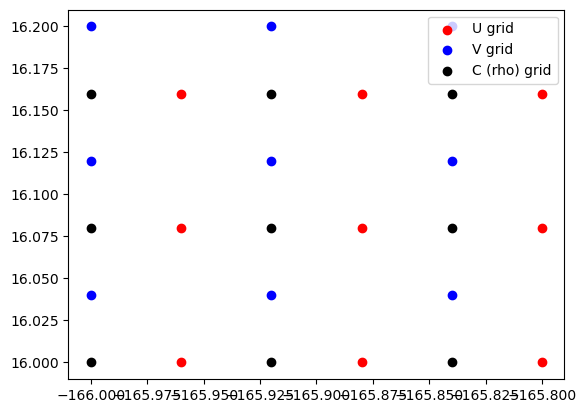

In [189]:
nind = 3
plt.scatter(roms.lon_u.values[:nind, :nind], roms.lat_u.values[:nind, :nind], c ="r", label = "U grid")
plt.scatter(roms.lon_v.values[:nind, :nind], roms.lat_v.values[:nind, :nind], c ="b", label = "V grid")
plt.scatter(roms.lon_rho.values[:nind, :nind], roms.lat_rho.values[:nind, :nind], c ="k", label = "C (rho) grid")
plt.legend(loc="upper right")

In [203]:
filenames = f"{dataset_folder}/roms/test134cars_npo0.08_07e_2022*.nc"

variables = {"U": "u", "V": "v"}

# Note that all variables need the same dimensions in a C-Grid
c_grid_dimensions = {
    "lon": "lon_rho",
    "lat": "lat_rho",
    "time": "ocean_time",
}

dimensions = {
    "U": c_grid_dimensions,
    "V": c_grid_dimensions,
}

indices = {"lon": range(0,600), "lat": range(0,375)}

In [205]:
fieldset = parcels.FieldSet.from_mitgcm(
    filenames, variables, dimensions, indices
) 

In [207]:
# fieldset

In [206]:
print("Dataset size:", len(fieldset.U.grid.lon)*len(fieldset.U.grid.lat)*len(fieldset.U.grid.time))

Dataset size: 6975000


### Amphitrite

In [208]:
folders = glob.glob(f"{dataset_folder}/amphitrite/*")

amph = xr.open_dataset(glob.glob(f"{folders[0]}/*.nc")[0])

In [209]:
for attr in amph.u.attrs:
    print(attr, ":", amph.u.attrs[attr])
for attr in amph.attrs:
    print(attr, ":", amph.attrs[attr])

units : meters/second
standard_name : surface_eastward_sea_water_velocity
long_name : Eastward surface current velocity


In [210]:
filenames = []

for folder in folders: 
    filenames.append(glob.glob(f"{folder}/*.nc")[0])

variables = {"U": "u", "V": "v"}

dimensions = {"time": "time", "lon": "longitude", "lat": "latitude"}

In [211]:
fieldset = parcels.FieldSet.from_netcdf(
    filenames, variables, dimensions
) 

In [212]:
# fieldset

In [213]:
print("Dataset size:", len(fieldset.U.grid.lon)*len(fieldset.U.grid.lat)*len(fieldset.U.grid.time))

Dataset size: 58397521


#### Advection

In [ ]:
# parcels.timer.root = parcels.timer.Timer("root")##
# parcels.timer.fieldset = parcels.timer.Timer("fieldset creation", parent=parcels.timer.root)
# parcels.timer.fieldset.stop()
# # parcels.timer.root.stop()
# parcels.timer.root.print_tree()

In [161]:
# Define a new particleclass with Variable 'age' with initial value 0.
AgeParticle = parcels.JITParticle.add_variable(parcels.Variable("age", initial=0))

In [162]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=AgeParticle, # parcels.JITParticle,
    size=10,  # releasing particles
    start=(-145, 25),  # releasing on a line: the start longitude and latitude
    finish=(-148, 25),  # releasing on a line: the end longitude and latitude
)

In [ ]:
output_file = pset.ParticleFile(
    name="NEMOParticles.zarr", outputdt=timedelta(days=1)
)
pset.execute(
    parcels.AdvectionRK4,
    runtime=timedelta(days=7),
    dt=timedelta(hours=1),
    output_file=output_file,
)

In [ ]:
ds = xr.open_zarr("NEMOParticles.zarr")
ds.traj.plot(margin=2)
plt.show()

## Sampling a Field with Particles

https://archimer.ifremer.fr/doc/00157/26792/24888.pdf 

In [29]:
# this flow does not depend on time, we need to set allow_time_extrapolation=True when reading in the fieldset

example_dataset_folder = parcels.download_example_dataset("Peninsula_data")
fieldset = parcels.FieldSet.from_parcels(
    f"{example_dataset_folder}/peninsula",
    extra_fields={"P": "P"},
    allow_time_extrapolation=True,
)

In [30]:
SampleParticle = parcels.JITParticle.add_variable("p")

In [ ]:
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset,
    pclass=SampleParticle,
    start=(3000, 3000),
    finish=(3000, 46000),
    size=5,
    time=0,
)

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.plot(pset.lon, pset.lat, "ko")
plt.show()

In [34]:
def SampleP(particle, fieldset, time):
    """Custom function that samples fieldset.P at particle location"""
    particle.p = fieldset.P[time, particle.depth, particle.lat, particle.lon]

In [ ]:
output_file = pset.ParticleFile(
    name="PeninsulaPressure.zarr", outputdt=timedelta(hours=1)
)
pset.execute(
    [parcels.AdvectionRK4, SampleP],  # list of kernels to be executed
    runtime=timedelta(hours=20),
    dt=timedelta(minutes=5),
    output_file=output_file,
)

In [ ]:
ds = xr.open_zarr("PeninsulaPressure.zarr")

plt.contourf(fieldset.P.grid.lon, fieldset.P.grid.lat, fieldset.P.data[0, :, :])
plt.xlabel("Zonal distance [m]")
plt.ylabel("Meridional distance [m]")
plt.colorbar()

plt.scatter(ds.lon, ds.lat, c=ds.p, s=30, cmap="viridis", edgecolors="k")
plt.show()

## Calculating distance travelled

In [37]:
# to_write to write in output file

extra_vars = [
    parcels.Variable("distance", initial=0.0, dtype=np.float32),
    parcels.Variable(
        "prev_lon", dtype=np.float32, to_write=False, initial=attrgetter("lon")
    ),
    parcels.Variable(
        "prev_lat", dtype=np.float32, to_write=False, initial=attrgetter("lat")
    ),
]

DistParticle = parcels.JITParticle.add_variables(extra_vars)

In [38]:
def TotalDistance(particle, fieldset, time):
    """Calculate the distance in latitudinal direction
    (using 1.11e2 kilometer per degree latitude)"""
    lat_dist = (particle.lat - particle.prev_lat) * 1.11e2
    lon_dist = (
        (particle.lon - particle.prev_lon)
        * 1.11e2
        * math.cos(particle.lat * math.pi / 180)
    )
    # Calculate the total Euclidean distance travelled by the particle
    particle.distance += math.sqrt(math.pow(lon_dist, 2) + math.pow(lat_dist, 2))

    # Set the stored values for next iteration
    particle.prev_lon = particle.lon
    particle.prev_lat = particle.lat

In [39]:
example_dataset_folder = parcels.download_example_dataset("GlobCurrent_example_data")
filenames = {
    "U": f"{example_dataset_folder}/20*.nc",
    "V": f"{example_dataset_folder}/20*.nc",
}
variables = {
    "U": "eastward_eulerian_current_velocity",
    "V": "northward_eulerian_current_velocity",
}
dimensions = {"lat": "lat", "lon": "lon", "time": "time"}
fieldset = parcels.FieldSet.from_netcdf(filenames, variables, dimensions)
pset = parcels.ParticleSet.from_line(
    fieldset=fieldset, pclass=DistParticle, size=5, start=(28, -33), finish=(30, -33)
)

In [ ]:
pset.execute(
    [parcels.AdvectionRK4, TotalDistance],  # list of kernels to be executed
    runtime=timedelta(days=6),
    dt=timedelta(minutes=5),
    output_file=pset.ParticleFile(
        name="GlobCurrentParticles_Dist.zarr", outputdt=timedelta(hours=1)
    ),
)

In [ ]:
print([p.distance for p in pset])